In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, urllib, itertools, shutil, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import PIL

In [2]:
path_to_folder = '/Users/smirn/Desktop/snake_dataset'
os.chdir(path_to_folder)

In [3]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Function to get random samples from test set
def get_random_test_imgs():
    random_test_imgs = []
    for idx, _ in enumerate(classes):
        if idx == 0:
            row = random.sample(range(0, test_for_class - 1), columns)
        else:
            row = random.sample(range(test_for_class * idx, test_for_class * (idx + 1) - 1), columns)
            
        random_test_imgs.extend(row)

    return random_test_imgs

In [4]:
classes = ['natrix', 'vipera', 'coronella', 'random']

# Get images distribution between classes and train/test/validation
def get_sets_amount(valid_x, test_x):
    count_images = 0

    folders = [x for x in os.listdir(path_to_folder) if not x.startswith(".")]
    for folder in folders:
        path = os.path.join(path_to_folder, folder)
        for image in os.listdir(path):
            image_path = os.path.join(path, image)
            if os.path.isfile(image_path) and not image.startswith("."):
                count_images += 1

    valid_amount = int(count_images * valid_x)
    test_amount = int(count_images * test_x)
    train_amount = count_images - valid_amount - test_amount

    return train_amount, valid_amount, test_amount

train_amount, valid_amount, test_amount = get_sets_amount(0.15, 0.05)
valid_for_class = round(valid_amount / len(classes))
test_for_class = round(test_amount / len(classes))

print(f'Train images: {train_amount}\nValid images: {valid_amount}\nTest images: {test_amount}')

Train images: 1526
Valid images: 285
Test images: 95


In [5]:
# Divide images into train, valid and test
# Distribute between folders
os.chdir(path_to_folder)
if os.path.isdir('train') is False:
    
    if not os.path.exists('valid'):
        os.mkdir('valid')
    if not os.path.exists('test'):
        os.mkdir('test')

    for name in classes:
        shutil.copytree(f'{name}_images', f'train/{name}')
        if not os.path.exists(f'valid/{name}'):
            os.mkdir(f'valid/{name}')
        if not os.path.exists(f'test/{name}'):
            os.mkdir(f'test/{name}')

        valid_samples = random.sample(os.listdir(f'train/{name}'), round(valid_amount / len(classes)))
        for j in valid_samples:
            shutil.move(f'train/{name}/{j}', f'valid/{name}')
        
        test_samples = random.sample(os.listdir(f'train/{name}'), round(test_amount / len(classes)))
        for k in test_samples:
            shutil.move(f'train/{name}/{k}', f'test/{name}')

    print('Created train, valid and test directories')

os.chdir('../..')

Created train, valid and test directories


In [6]:
# Create generators train, valid and test 
# Preprocess images for mobilenet
batch_size = 20
train_path = os.path.join(path_to_folder, 'train')
valid_path = os.path.join(path_to_folder, 'valid')
test_path = os.path.join(path_to_folder, 'test')
target_size = (224, 224)

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=train_path, target_size=target_size, classes=classes, batch_size=batch_size)

valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=target_size, classes=classes, batch_size=batch_size)

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=test_path, target_size=target_size, classes=classes, batch_size=batch_size, shuffle=False)

Found 1524 images belonging to 4 classes.
Found 283 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


In [7]:
# Load pretrained model
mobile_net = keras.applications.DenseNet121()

In [8]:
# Let's look at this model, choose which last layers to replace
mobile_net.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

In [9]:
# Leave all layers except for last 5 
# Add output layer with activation function softmax for defining the class
x = mobile_net.layers[-1].output
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=mobile_net.input, outputs=output)

In [10]:
# When training we will work with weights of last 23 layers
for layer in model.layers[:-24]:
    layer.trainable = False

In [11]:
# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=7,
    min_delta=0.001,
    restore_best_weights=True,
)

# Compile the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
%%time
# Train model
history = model.fit(
    x=train_batches, 
    validation_data=valid_batches, 
    epochs=25, 
    callbacks=[early_stopping]
)

Epoch 1/25
77/77 [==============================] - 132s 2s/step - loss: 1.3071 - accuracy: 0.7638 - val_loss: 1.2447 - val_accuracy: 0.8339
Epoch 2/25
77/77 [==============================] - 142s 2s/step - loss: 1.1804 - accuracy: 0.8970 - val_loss: 1.1215 - val_accuracy: 0.9223
Epoch 3/25
77/77 [==============================] - 121s 2s/step - loss: 1.0727 - accuracy: 0.9350 - val_loss: 1.0383 - val_accuracy: 0.9152
Epoch 4/25
77/77 [==============================] - 134s 2s/step - loss: 0.9787 - accuracy: 0.9423 - val_loss: 0.9665 - val_accuracy: 0.8905
Epoch 5/25
77/77 [==============================] - 137s 2s/step - loss: 0.8827 - accuracy: 0.9554 - val_loss: 0.8952 - val_accuracy: 0.8869
Epoch 6/25
77/77 [==============================] - 127s 2s/step - loss: 0.8043 - accuracy: 0.9587 - val_loss: 0.8094 - val_accuracy: 0.9152
Epoch 7/25
77/77 [==============================] - 127s 2s/step - loss: 0.7242 - accuracy: 0.9711 - val_loss: 0.7208 - val_accuracy: 0.9470
Epoch 8/25
77

<AxesSubplot:title={'center':'Accuracy'}>

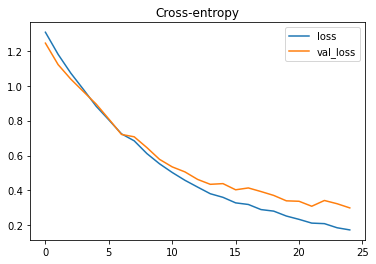

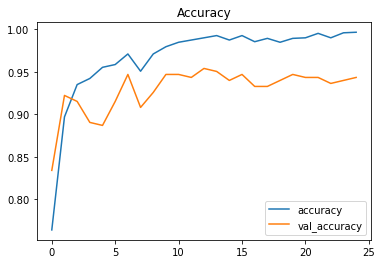

In [13]:
# Analyze loss functions (train and valid)
# We need to minimize val_loss
# without overfitting it on train set 
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [14]:
# Check accuracy for images, which model hasn't seen before
scores = model.evaluate(test_batches)
print(f'Accuracy: {round((scores[1]*100), 2)}%')

5/5 [==============================] - 6s 1s/step - loss: 0.3349 - accuracy: 0.9375
Accuracy: 93.75%


5/5 [==============================] - 8s 1s/step


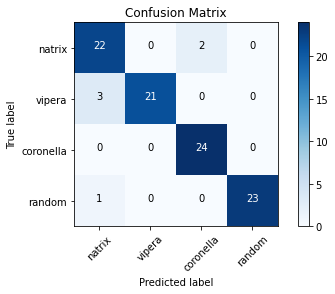

In [15]:
# Plot confusion matrix
preds = model.predict(test_batches)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

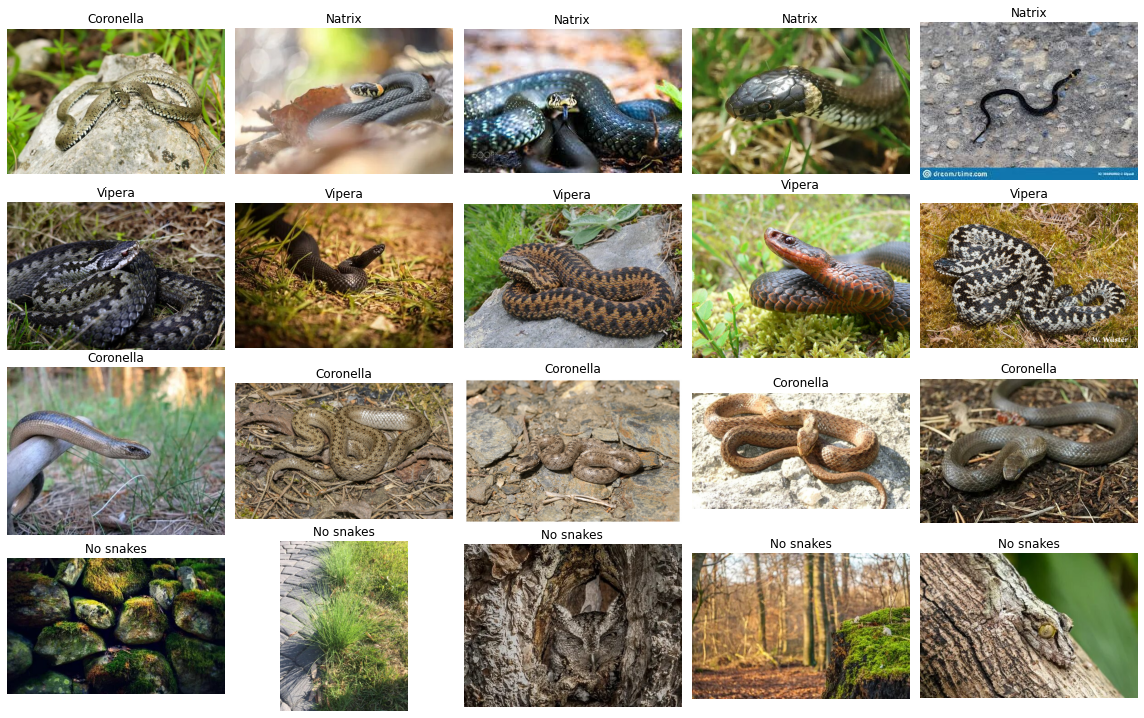

In [16]:
preds_catigorical = pd.Series(np.argmax(preds, axis=1)).replace({0: 'Natrix', 1: 'Vipera', 2: 'Coronella', 3: 'No snakes'})
columns = 5

fig, ax = plt.subplots(nrows=len(classes), ncols=columns, figsize=[16, 10])
random_test_imgs = get_random_test_imgs()

for i, axi in enumerate(ax.flat):
    image = PIL.Image.open(test_batches.filepaths[random_test_imgs[i]])
    axi.imshow(image)
    axi.set_title(preds_catigorical[random_test_imgs[i]])
    axi.axis('off')
    plt.tight_layout()

plt.show()

In [18]:
model.save('/Users/smirn/PycharmProjects/snake-bot/model')

INFO:tensorflow:Assets written to: /Users/smirn/PycharmProjects/snake-bot/model\assets


INFO:tensorflow:Assets written to: /Users/smirn/PycharmProjects/snake-bot/model\assets
